In [17]:
import pandas as pd
from pathlib import Path
from unidecode import unidecode
import collections
import re
import matplotlib.pyplot as plt
from collections import defaultdict

### Processing 



In [18]:
# Set the absolute path to your data directory
data_directory = Path("E:/panag/Desktop/Ms Data Science/6 Quarter/Data Science Challenge/data_challenge_aueb_2023")

# Train data
y_train_file = "y_train.txt"
# Authors data
authors_file = "authors_v2.txt"
# Test data
test_file = "test.txt"

y_train_path = data_directory / y_train_file
authors_path = data_directory / authors_file
test_path     = data_directory / test_file
output_csv_path =  "features_authors.csv"

In [19]:
#### 1. Create author dictionary ####
#####################################
# Read the 'authors.txt' file
with open(authors_path, "r") as file:
    lines = file.readlines()

# Create the authors_dict
authors_dict = {int(line.split('||')[0]): line.split('||')[1].strip() for line in lines}


#### 2. Create filtered author dictionary ####
##############################################
# Get paper ids from training data
df_train = pd.read_csv(y_train_path, header=None)
df_train.columns = ['paper_id','class']
# Get paper ids from test data
df_test = pd.read_csv(test_path, header=None)
df_test.columns = ['paper_id','class_to_predict']
# Get total paper ids
paper_ids = tuple(df_train['paper_id'].values) + tuple(df_test['paper_id'].values)
# Create filtered author dictionary
filter_authors_dict = {paper_id: authors_dict[paper_id] for paper_id in paper_ids if paper_id in authors_dict}


#### 3. Create filtered/cleaned author dictionary ####
######################################################
cleaned_authors_dict = {}
for paper_id, authors in filter_authors_dict.items():
    cleaned_authors = []
    for author in authors.split('|*'):
        # Replace Unicode characters
        author = unidecode(author)
        # Convert to lowercase
        author = author.lower()
        # Remove numerical characters
        author = re.sub(r'\d', '', author)
        # Remove single characters followed by a fullstop
        author = re.sub(r'\b\w\.\s*', '', author)
        # Remove single characters
        author = re.sub(r'\b\w\b','', author)
        # Remove commas
        author = author.replace(',', '')
        # Remove any double spaces
        author = re.sub(r'  ', ' ', author)
        # Remove leading/trailing white spaces
        author = author.strip()
        cleaned_authors.append(author)

    cleaned_authors_dict[paper_id] = '|*'.join(cleaned_authors)


#### 4. Create authors to papers dict ####
##########################################
author_to_papers_dict = {}
for paper_id, authors in cleaned_authors_dict.items():
    for author in authors.split('|*'):
        # If the author is not a key in the dictionary, add the author as a key with a value of an empty list
        if author not in author_to_papers_dict:
            author_to_papers_dict[author] = []
        # Add the paper id to the list of paper ids for this author
        author_to_papers_dict[author].append(paper_id)


#### 5. Replace paper ids with their class ####
###############################################
author_to_classes_dict = {}
# Create a dictionary to map each paper id to its class
paper_id_to_class_dict = df_train.set_index('paper_id')['class'].to_dict()
for author, paper_ids in author_to_papers_dict.items():
    # Initialize the list of classes for this author
    classes = []
    for paper_id in paper_ids:
        # If the paper id is in the dictionary, add its class to the list of classes
        if paper_id in paper_id_to_class_dict:
            classes.append(paper_id_to_class_dict[paper_id])
    # Add the author and their list of classes to the dictionary
    author_to_classes_dict[author] = classes


#### 6. Keep the most common class for each author ####
#######################################################
author_to_most_common_classes_dict = {}
for author, classes in author_to_classes_dict.items():
    # If the author has no classes, skip them
    if not classes:
        continue
    # Count the frequency of each class
    class_counts = collections.Counter(classes)
    # Get the count of the most common class
    max_count = class_counts.most_common(1)[0][1]
    # Get all classes that have the maximum count
    most_common_classes = [cls for cls, count in class_counts.items() if count == max_count]
    # Add the author and their most common class(es) to the dictionary
    author_to_most_common_classes_dict[author] = most_common_classes


#### 7a. Get the most frequent author class for each paper id  ####
##################################################################
paper_id_to_classes_dict = {}
for paper_id, authors in cleaned_authors_dict.items():
    # Initialize the list of classes for this paper
    classes = []
    for author in authors.split('|*'):
        # If the author has a most common class, add it to the list of classes
        if author in author_to_most_common_classes_dict:
            classes.extend(author_to_most_common_classes_dict[author])
    # Add the paper id and its list of classes to the dictionary
    paper_id_to_classes_dict[paper_id] = classes


#### 7b. Get all author classes for each paper id  ####
######################################################
paper_id_to_all_classes_dict = {}
for paper_id, authors in cleaned_authors_dict.items():
    # Initialize the list of classes for this paper
    classes = []
    for author in authors.split('|*'):
        # If the author has classes, add them to the list of classes
        if author in author_to_classes_dict:
            classes.extend(author_to_classes_dict[author])
    # Add the paper id and its list of classes to the dictionary
    paper_id_to_all_classes_dict[paper_id] = classes


######## In step 8 we can select either the dict from step 7a or 7b ##########

#### 8. Create final Dataframe/ export to csv ####
###################################
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(paper_id_to_all_classes_dict.items()), columns=['paper_id', 'classes']) 
# Transform each element of a list-like to a row
df = df.explode('classes')  
# Convert the categorical class variable into dummy/indicator variables
df = pd.get_dummies(df, columns=['classes']) 
# Aggregate the data by paper id and calculate the sum of the dummy variables
df = df.groupby('paper_id').sum().reset_index()   
# Rename the columns
df.columns = ['paper_id', 'class0', 'class1', 'class2', 'class3', 'class4']

# Calculate class weights
for i in range(5):
    df[f'class{i}_weight'] = 0.0
# Iterate through the DataFrame and populate the new columns
for idx, row in df.iterrows():
    class_counts = [row[f'class{i}'] for i in range(5)]
    total_counts = sum(class_counts)   
    # Calculate the class weights
    if total_counts > 0:
        class_weights = [count / total_counts for count in class_counts]
    else:
        class_weights = [0.0 for _ in class_counts]
    # Update the new columns with the weights
    for i, weight in enumerate(class_weights):
        df.at[idx, f'class{i}_weight'] = weight

# Add total_references column
df['total_references'] = df[[f'class{j}' for j in range(5)]].sum(axis=1)

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

### Results

In [4]:
df.head(5)

,paper_id,class0,class1,class2,class3,class4,class0_weight,class1_weight,class2_weight,class3_weight,class4_weight,total_references
0,2,1.0,0.0,0.0,0.0,32.0,0.030303,0.000000,0.0,0.0,0.969697,33.0
1,3,0.0,0.0,0.0,19.0,0.0,0.000000,0.000000,0.0,1.0,0.000000,19.0
2,6,31.0,1.0,0.0,0.0,1.0,0.939394,0.030303,0.0,0.0,0.030303,33.0
3,8,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000,1.0
4,13,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.0,0.0,1.000000,2.0


### Plots

Number of authors with no class:     3323
Percentage of authors with no class: 6.31 %


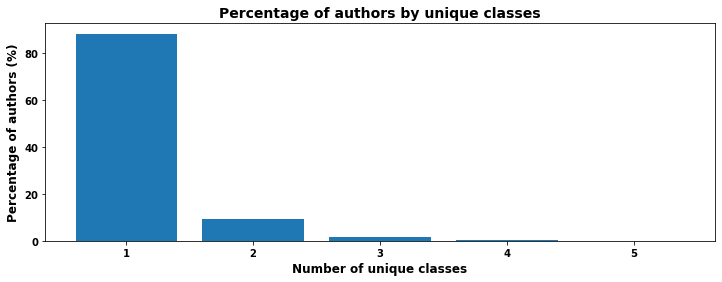

In [25]:
# Count unique classes for each author, exclude those with no classes
author_classes = {author: len(set(papers)) for author, papers in author_to_classes_dict.items() if papers}

# Count the number of authors with no classes
no_class_authors = len([author for author, papers in author_to_classes_dict.items() if not papers])
print(f"Number of authors with no class:     {no_class_authors}")
print(f"Percentage of authors with no class: {format(no_class_authors/len(author_to_classes_dict)*100, '.2f')} %")

# Count the number of authors for each number of unique classes
class_counts = defaultdict(int)
for num_classes in author_classes.values():
    class_counts[num_classes] += 1

# Calculate the total number of authors
total_authors = len(author_to_classes_dict)

# Calculate the percentage for each class count
class_percentages = {k: (v / (total_authors - no_class_authors)) * 100 for k, v in class_counts.items()}

# Plot
plt.figure(figsize=(12, 4))
plt.bar(class_percentages.keys(), class_percentages.values())
plt.xlabel('Number of unique classes', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of authors (%)', fontsize=12, fontweight='bold')
plt.title('Percentage of authors by unique classes', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.show()

Number of papers with no class based on authors:     208
Percentage of papers with no class based on authors: 0.53 %


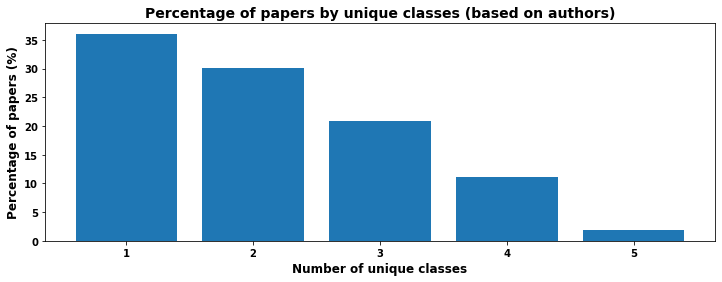

In [24]:
# Count unique classes for each paper, exclude those with no classes
paper_classes = {paper: len(set(classes)) for paper, classes in paper_id_to_all_classes_dict.items() if classes}

# Count the number of papers with no classes
no_class_papers = len([paper for paper, classes in paper_id_to_all_classes_dict.items() if not classes])
print(f"Number of papers with no class based on authors:     {no_class_papers}")
print(f"Percentage of papers with no class based on authors: {format(no_class_papers/len(paper_id_to_all_classes_dict)*100, '.2f')} %")

# Count the number of papers for each number of unique classes
class_counts = defaultdict(int)
for num_classes in paper_classes.values():
    class_counts[num_classes] += 1

# Calculate the total number of papers
total_papers = len(paper_id_to_all_classes_dict)

# Calculate the percentage for each class count
class_percentages = {k: (v / (total_papers - no_class_papers)) * 100 for k, v in class_counts.items()}

# Plot
plt.figure(figsize=(12, 4))
plt.bar(class_percentages.keys(), class_percentages.values())
plt.xlabel('Number of unique classes', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of papers (%)', fontsize=12, fontweight='bold')
plt.title('Percentage of papers by unique classes (based on authors)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.show()